# SIRD model playground

Given the following equations of the SIRD model

\begin{align*}
\frac{dS}{dt} &= -\beta \cdot S \cdot I \\
\frac{dI}{dt} &= \beta \cdot S \cdot I - (\gamma \cdot I) - (\delta \cdot I) \\
\frac{dR}{dt} &= \gamma \cdot I \\
\frac{dD}{dt} &= \delta \cdot I
\end{align*}

Given the initial conditions: *population, cases, deaths, recovered* and *Basic reproductive rate (R0), Mortality rate ratio (M), Average infectios period (P)* it is possible to compute the correspondent ODEs and then obtain the *S, I, R, D* params

In [6]:
from sird_base_model import SIRD
import matplotlib.pyplot as plt
import pandas as pd
from pso import MyPSO, BaselineConfig, TimeVaryingConfig

class ExperimentType:
    BASELINE = 0
    TIME_VARYING = 1

Experiment_type = ExperimentType.TIME_VARYING
# Experiment_type = ExperimentType.BASELINE

if Experiment_type == ExperimentType.BASELINE:
    config = BaselineConfig()
elif Experiment_type == ExperimentType.TIME_VARYING:
    config = TimeVaryingConfig()
else:
    raise ValueError("Invalid Experiment Type")

DAYS = config.DAYS
LAG = config.LAG

print(F"USING LAG: {LAG}, DAYS: {DAYS}")
parent_class = MyPSO(config=config)

USING LAG: 0, DAYS: 28


In [7]:
def get_params_from_file():
    FOLDER = f"../data/solutions/{config.NAME}.csv"
    with open(FOLDER) as f:
        res = pd.read_csv(f)
        # convert to single dict with keys = [params]
        res = res.to_dict(orient="records")
    return res

In [8]:
pso_params = get_params_from_file()
print(pso_params)

[{'beta': 0.2555044559663463, 'gamma': 0.0293893202414498, 'delta': 0.0233233496113006}, {'beta': 0.0651275740242907, 'gamma': 0.0191480764245501, 'delta': 0.0101622382575354}]


,Original_I,Original_R,Original_D
0,221,1,7
1,311,1,10
2,385,3,12
3,588,45,17
4,821,46,21
5,1049,50,29
6,1577,83,34
7,1835,149,52
8,2263,160,79
9,2706,276,107


,Original_S
0,59999771
1,59999678
2,59999600
3,59999350
4,59999112
5,59998872
6,59998306
7,59997964
8,59997498
9,59996911


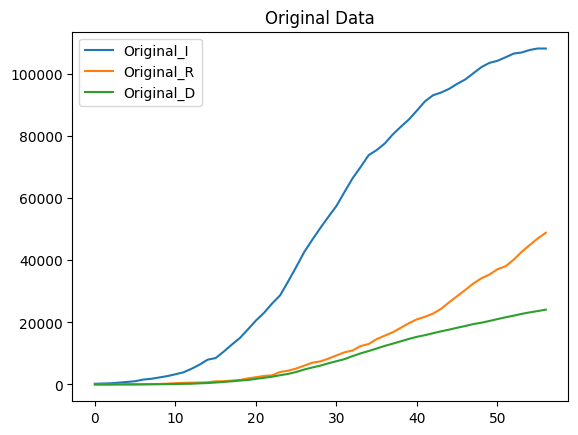

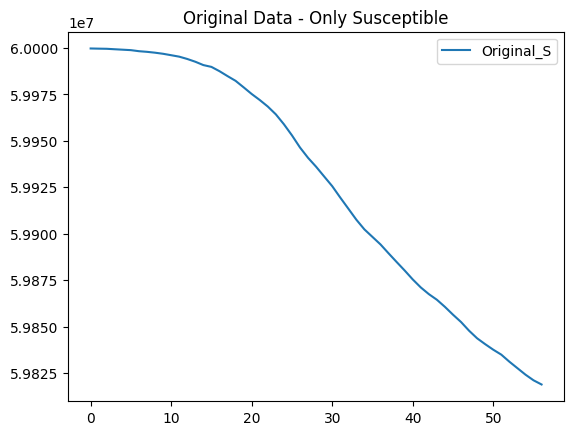

In [9]:
USE_SUSCEPTIBLE = True

# Viz real data
df = pd.read_csv('../data/daily_processed.csv')
# Lineplot totale_positivi, dimessi_guariti, deceduti giving iloc

if Experiment_type == ExperimentType.BASELINE:
    row_interval = slice(LAG,LAG+DAYS+1)
elif Experiment_type == ExperimentType.TIME_VARYING:
    row_interval = slice(LAG,(DAYS*config.SEGMENTS)+LAG+1)
else:
    raise ValueError("Invalid Experiment Type")
original_df = df.iloc[row_interval, 1:4]
# Rename columns
original_df.columns = ['Original_I', 'Original_R', 'Original_D']
display(original_df)
original_df.plot(title="Original Data")

if USE_SUSCEPTIBLE:
    # Show only susceptible
    original_only_sus_df = df.iloc[row_interval, 4:5]
    original_only_sus_df.columns = ['Original_S']
    display(original_only_sus_df)
    original_only_sus_df.plot(title="Original Data - Only Susceptible")

{'population': 60000000, 'initial_I': 221.0, 'initial_R': 1.0, 'initial_D': 7.0, 'initial_S': 59999771.0}
0
1


,Computed_I,Computed_R,Computed_D
0,221.000000,1.000000,7.000000
1,270.708511,8.289022,12.755447
2,331.591951,17.216697,19.804781
3,406.129221,28.146526,28.435026
4,497.453685,41.537987,39.008988
5,609.369750,57.948965,51.967175
6,753.874574,79.142006,68.701301
7,948.453078,107.687549,91.240998
8,1181.872227,141.932450,118.280935
9,1447.999487,180.972187,149.106898


,Computed_S
0,5.999977e+07
1,5.999971e+07
2,5.999963e+07
3,5.999954e+07
4,5.999942e+07
5,5.999928e+07
6,5.999910e+07
7,5.999885e+07
8,5.999856e+07
9,5.999822e+07


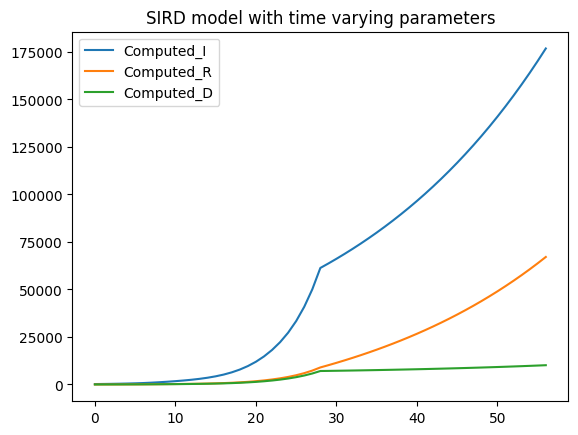

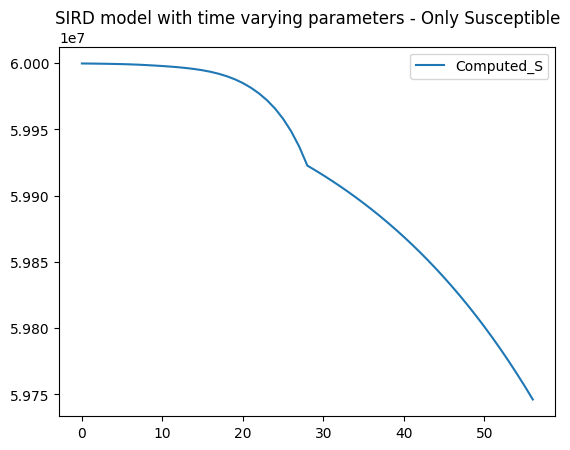

In [5]:
# Computing SIRD values using SIRD model + PSO obtained params

# Initial state of the system
initial_conditions, _ = parent_class.get_sird_from_data(start_week=LAG, end_week=LAG+DAYS, population=parent_class.population)
model_df = pd.DataFrame({'Computed_I': [], 'Computed_R': [], 'Computed_D': []})
model_df = pd.concat([model_df, pd.DataFrame({'Computed_I': initial_conditions['initial_I'], 'Computed_R': initial_conditions['initial_R'], 'Computed_D': initial_conditions['initial_D']}, index=[0])])

if USE_SUSCEPTIBLE:
    model_only_sus_df = pd.DataFrame({'Computed_S': initial_conditions['initial_S']}, index=[0])
    
print(initial_conditions)
if Experiment_type == ExperimentType.BASELINE:
    params = pso_params[0]
    model_base = SIRD(beta=params['beta'], gamma=params['gamma'], delta=params['delta'])
    model_base.solve(initial_conditions, time_frame=DAYS)
    s,i,r,d, _ = model_base.get_sird_values().values()
    model_df = pd.DataFrame({'Computed_I': i, 'Computed_R': r, 'Computed_D': d})
    model_df.reset_index(drop=True, inplace=True)
    display(model_df)
    model_df.plot(title='SIRD model with baseline parameters')

    if USE_SUSCEPTIBLE:
        model_only_sus_df = pd.DataFrame({'Computed_S': s})
        display(model_only_sus_df)
        model_only_sus_df.plot(title='SIRD model with baseline parameters - Only Susceptible')

elif Experiment_type == ExperimentType.TIME_VARYING:
    # Iterate on each segment
    for segment_idx, params in enumerate(pso_params):
        print(segment_idx)
        model_tvar = SIRD(beta=params['beta'], gamma=params['gamma'], delta=params['delta'])
        model_tvar.solve(initial_conditions, time_frame=DAYS)
        s,i,r,d, _ = model_tvar.get_sird_values().values()
        initial_conditions = {'population': parent_class.population, 'initial_I': i[-1], 'initial_R': r[-1], 'initial_D': d[-1], 'initial_S': s[-1]}
        model_df = pd.concat([model_df, pd.DataFrame({'Computed_I': i[1:], 'Computed_R': r[1:], 'Computed_D': d[1:]})])
        if USE_SUSCEPTIBLE:
            model_only_sus_df = pd.concat([model_only_sus_df, pd.DataFrame({'Computed_S': s[1:]})])
    model_df.reset_index(drop=True, inplace=True)
    display(model_df)
    model_df.plot(title="SIRD model with time varying parameters")

    if USE_SUSCEPTIBLE:
        model_only_sus_df.reset_index(drop=True, inplace=True)
        display(model_only_sus_df)
        model_only_sus_df.plot(title="SIRD model with time varying parameters - Only Susceptible")

In [10]:
# Compare the original data with the computed sird values
# Change the order of legend items so that i have Original_I, Computed_I, Original_R, Computed_R, Original_D, Computed_D

# params contains an array of dict contianing beta, gamma, delta 
# i want to put them in the title using markdown syntax
params_len = len(pso_params)
segments = config.SEGMENTS if Experiment_type == ExperimentType.TIME_VARYING else 1
# Get all params from the dict given a key. E.g. get_pk(params, 'beta') -> [0.1, 0.2, 0.3]
get_pk = lambda k: [round(p[k],3) for p in pso_params]
params_title = f"\nWeights = [S: {config.weight_S}, I: {config.weight_I}, R: {config.weight_R}, D: {config.weight_D}]\nGenerations: {config.MAX_GENERATIONS}\nPopulation: {config.POPULATION_SIZE}\nSegments: {segments}\n\nBetas: {get_pk('beta')}\nGammas: {get_pk('gamma')}\nDeltas: {get_pk('delta')}\n"
print(params_title)
original_df.plot(ax=model_df.plot(), title=f'Original data vs SIRD model\n\n{params_title}')
# 0 3 1 5 2 5
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 0, 4, 1, 5, 2]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])

if USE_SUSCEPTIBLE:
    original_only_sus_df.plot(ax=model_only_sus_df.plot(), title=f'Original data vs SIRD model - Only Susceptible\n\n{params_title}')
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 0]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    


Weights = [S: 1, I: 2, R: 0.7, D: 0.4]
Generations: 400.0
Population: 100.0
Segments: 2

Betas: [0.256, 0.065]
Gammas: [0.029, 0.019]
Deltas: [0.023, 0.01]



NameError: name 'model_df' is not defined